In [2]:
import sys  
sys.path.insert(1, '../')
# from utils.dataset_utils import OriginalDataset
import torch
print(torch.cuda. get_device_name(torch.cuda.current_device()))

AssertionError: Torch not compiled with CUDA enabled

In [3]:
import os
from utils.dataset_utils import read_img, get_storage
from torchvision.datasets import VisionDataset
import numpy as np

def norm_value(s):
    # return (s + 255.0) / 510.0
    return s / 255

def denorm_value(s):
    # return (s * 510.0) - 255.0
    # print(f"{s = }")
    return torch.tensor(s * 255, dtype=torch.int8)

class OriginalDataset(VisionDataset):
    def __init__(self, data_path: str, color: bool=True):
        super(OriginalDataset, self).__init__()
        self.data_path = data_path
        self.color = color

    def __getitem__(self, idx: int):
        """
        this dataset returns the image corresponding to the index
        """

        if idx >= len(self) or idx < 0:
            # needed for iterator stop condition
            raise IndexError
        # the img_file_path existence check
        img_path = f'{self.data_path}/idx_{idx}.png'
        img2_path = f'{self.data_path}/idx_{idx+1}.png'
        assert os.path.exists(img_path), f"Invalid img_path: {img_path} in {self.data_path}"
        img1 = read_img(img_path, self.color)
        # img2 = read_img(img2_path, self.color)
        img1 = np.array(img1, dtype = np.float32)
        # img2 = np.array(img2, dtype = np.float32)
        # return norm_value(img2 - img1)
        return norm_value(img1)

    def __len__(self) -> int:
        dirpath, dir_names, files = next(os.walk(self.data_path))
        # return len([i for i in files if "resize" not in i]) - 1
        return len([i for i in files if "resize" not in i])

    def __str__(self):
        return f"OriginalDataset({self.data_path})"

    def get_storage_size(self, num_images):
        "returns the total storage size of the dataset"
        total_storage = 0
        for data in [self[i] for i in range(num_images)]:
            total_storage += get_storage(data)
        return total_storage

In [4]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)

166


In [5]:
original_dataset[0].shape

(180, 320, 3)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
from autoencoder import CNNAutoencoder, OriginalDataset

original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)



166


Training the model

In [2]:
model = CNNAutoencoder()
model.fit(original_dataset)

Epoch [ 1/50], Loss: 0.165325
Epoch [ 2/50], Loss: 0.052709
Epoch [ 3/50], Loss: 0.027926
Epoch [ 4/50], Loss: 0.020354
Epoch [ 5/50], Loss: 0.016257
Epoch [ 6/50], Loss: 0.013097
Epoch [ 7/50], Loss: 0.011102
Epoch [ 8/50], Loss: 0.010010
Epoch [ 9/50], Loss: 0.009200
Epoch [10/50], Loss: 0.008658
Epoch [11/50], Loss: 0.008207
Epoch [12/50], Loss: 0.007858
Epoch [13/50], Loss: 0.007492
Epoch [14/50], Loss: 0.007217
Epoch [15/50], Loss: 0.006995
Epoch [16/50], Loss: 0.006797
Epoch [17/50], Loss: 0.008447
Epoch [18/50], Loss: 0.006550
Epoch [19/50], Loss: 0.006270
Epoch [20/50], Loss: 0.006114
Epoch [21/50], Loss: 0.005969
Epoch [22/50], Loss: 0.005832
Epoch [23/50], Loss: 0.005727
Epoch [24/50], Loss: 0.005618
Epoch [25/50], Loss: 0.005517
Epoch [26/50], Loss: 0.005471
Epoch [27/50], Loss: 0.005299
Epoch [28/50], Loss: 0.005211
Epoch [29/50], Loss: 0.005135
Epoch [30/50], Loss: 0.005062
Epoch [31/50], Loss: 0.004970
Epoch [32/50], Loss: 0.004893
Epoch [33/50], Loss: 0.004821
Epoch [34/

/var/folders/zy/p43zwvr900bdn5gk6_hlhpxr0000gn/T/ipykernel_15972/3076756164.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s * 255, dtype=torch.int8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 8, 39, 74])
tensor([15, 32, 52], dtype=torch.int8)
tensor([22, 44, 57], dtype=torch.int8)


(-0.5, 319.5, 179.5, -0.5)

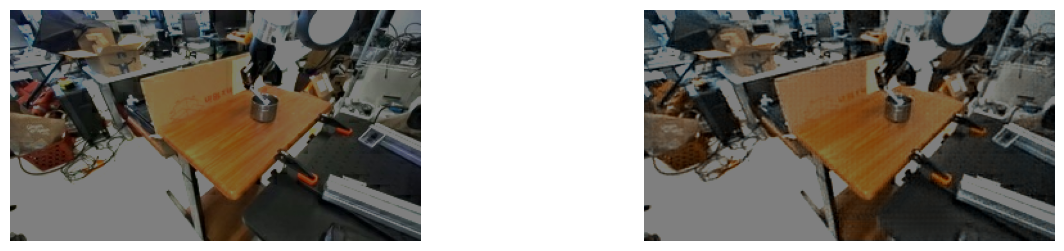

In [7]:
from autoencoder import load_model
import matplotlib.pyplot as plt

model = load_model(checkpoint="../checkpoints/lowest_loss_ae.pt")
train_loader = torch.utils.data.DataLoader(original_dataset, batch_size=4, shuffle=True)
test_image = next(iter(train_loader))[:1]
with torch.no_grad():
    reconstructed = model.test(test_image.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

print(denorm_value(test_image[0][0][0]))
print(denorm_value(reconstructed[0][0][0]))
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(denorm_value(test_image.squeeze()))
axes[0].axis('off')
axes[1].imshow(denorm_value(reconstructed.squeeze()))
axes[1].axis('off')

# @todo Billy can you do this?
we need to encode all the 166 images with the encoder, save the encoded vectors get the residual and write a function that will give us the total size of the models and the encoded vector.

start
166
torch.Size([166, 180, 320, 3])
process time = 19.101500034332275
x_hid.size()=torch.Size([166, 32, 37, 72])


/Users/billyslim/Desktop/UTN/HiWi/robotics_dataset_compression/research/autoencoder.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s * 255, dtype=torch.int8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([166, 32, 37, 72])
tensor([26, 28, 53], dtype=torch.int8)
tensor([18, 33, 52], dtype=torch.int8)


(-0.5, 319.5, 179.5, -0.5)

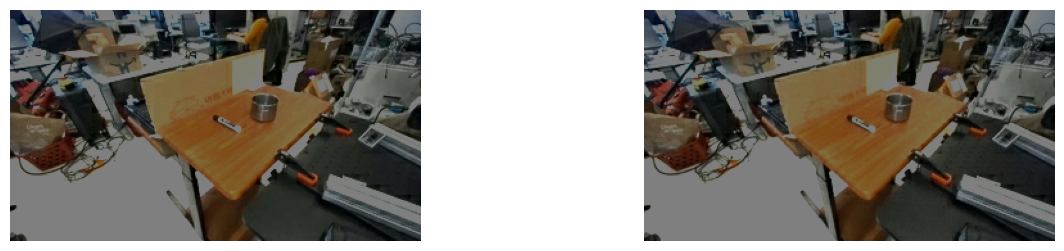

In [8]:
import sys  
sys.path.insert(1, '../')
from autoencoder import load_model, denorm_value, norm_value
from utils.dataset_utils import OriginalDataset
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

start_time = time.time()
model = load_model(checkpoint="../checkpoints/lowest_loss_ae_5000.pt")
# model = load_model(checkpoint="../checkpoints/lowest_loss_ae.pt")
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print("start")
all_images = []
for i in range(len_):
    img_org = original_dataset[i]
    all_images.append(img_org)
print(len(all_images))
all_images = torch.tensor(all_images, dtype=torch.float)
print(all_images.shape)
all_images = norm_value(all_images)
print(f"process time = {time.time() - start_time}")
with torch.no_grad():
    reconstructed, feature = model.test(all_images.permute(0, 3, 1, 2))
    reconstructed = reconstructed.permute(0, 2, 3, 1)
print(feature.shape)
# print(img_org[0][0])
print(denorm_value(all_images[0][0][0]))
print(denorm_value(reconstructed[0][0][0]))
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(denorm_value(all_images[0].squeeze()))
axes[0].axis('off')
axes[1].imshow(denorm_value(reconstructed[0].squeeze()))
axes[1].axis('off')

In [9]:
i, h, w, c = feature.shape
feature_pixel_channel = i * h * w * c
print(f"data size: {feature_pixel_channel * 4 / 1024 / 1024} MB")

data size: 53.982421875 MB


In [10]:
reconstructed = np.array(denorm_value(reconstructed), dtype=np.int16)
all_images = np.array(denorm_value(all_images), dtype=np.int16)
diff = all_images - reconstructed
i, h, w, c = diff.shape
pixel_channel = i * h * w * c
zero_cnt = np.sum(diff == 0)
threshold = 16
threshold_cnt = np.sum(np.abs(diff) <= threshold)
print(f"total number of pixels: {pixel_channel}")
print(f"zero pixels: {zero_cnt}")
print(f"zero pixels ratio: {zero_cnt / pixel_channel}")
print(f"threshold pixels: {threshold_cnt}")
print(f"threshold pixels ratio: {threshold_cnt / pixel_channel}")
# for i in range(166):
#     diff = all_images[i] - reconstructed[i]
#     h, w, c = diff.shape
#     pixel_channel = h * w * c
#     zero_cnt = np.sum(diff == 0)
#     threshold = 16
#     threshold_cnt = np.sum(np.abs(diff) <= threshold)
#     print(f"total number of pixels: {pixel_channel}")
#     print(f"zero pixels: {zero_cnt}")
#     print(f"zero pixels ratio: {zero_cnt / pixel_channel}")
#     print(f"threshold pixels: {threshold_cnt}")
#     print(f"threshold pixels ratio: {threshold_cnt / pixel_channel}")


total number of pixels: 28684800
zero pixels: 11470475
zero pixels ratio: 0.399879901550647
threshold pixels: 28558513
threshold pixels ratio: 0.9955974244199018


In [11]:
import sys  
sys.path.insert(1, '../')
from utils.huffman_encoding import (get_freq_dict,
                                    build_huffman_tree,
                                    generate_huffman_codes,
                                    get_huffman_codes)
freq = get_freq_dict(diff)
root, huffmanCode, encoded_bits = get_huffman_codes(freq, extar_bits=0)

dict_bits = (len(freq) * 2) * 4 * 8
total_bits = encoded_bits + dict_bits
# total_bits = encoded_bits1 + encoded_bits2 + dict_bits
print(f"{len(freq) = }")
print(f"{total_bits = }")
print(f"In Bytes  = {total_bits / 8}")
print(f"In KB     = {total_bits / 8 / 1024}")
print(f"In MB     = {total_bits / 8 / 1024 / 1024}")

Character:   0, Code:                 0, Length of Code:  1, Frequency: 11470475
Character:   1, Code:              1111, Length of Code:  4, Frequency: 2999162
Character:  -1, Code:              1110, Length of Code:  4, Frequency: 2513579
Character:   2, Code:              1101, Length of Code:  4, Frequency: 2432203
Character:  -2, Code:              1010, Length of Code:  4, Frequency: 1780465
Character:   3, Code:              1001, Length of Code:  4, Frequency: 1688048
Character:  -3, Code:             11000, Length of Code:  5, Frequency: 1138611
Character:   4, Code:             10111, Length of Code:  5, Frequency: 1057985
Character:  -4, Code:             10000, Length of Code:  5, Frequency: 690228
Character:   5, Code:            110011, Length of Code:  6, Frequency: 628374
Character:  -5, Code:            101100, Length of Code:  6, Frequency: 412992
Character:   6, Code:            100010, Length of Code:  6, Frequency: 367954
Character:  -6, Code:           1011011, Le

In [27]:
diff = np.array(diff, dtype=np.int8).flatten()
hf_string = ""
for i in range(diff.shape[0]):
    # print(f"{diff[i]}: {huffmanCode[str(diff[i])]}")
    hf_string += huffmanCode[str(diff[i])]
    if i > 1000000:
        break
# print(hf_string)

In [30]:
def run_length_encode(data):
    encoded = []
    count = 1
    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded.append((data[i - 1], count))
            count = 1
    encoded.append((data[-1], count))
    return encoded

def build_rle_count_dictionary(rle_data):
    rle_dict = {}
    for item in rle_data:
        if item not in rle_dict:
            rle_dict[item] = 0
        rle_dict[item] += 1
    return rle_dict
compressed_data = run_length_encode(hf_string)
rle_count_dictionary = build_rle_count_dictionary(compressed_data)

# print("RLE Data:", compressed_data)
print("RLE Count Dictionary:", rle_count_dictionary)
print("RLE Count Dictionary Size:", len(rle_count_dictionary))

RLE Count Dictionary: {('0', 4): 43482, ('1', 4): 45795, ('0', 2): 214810, ('1', 2): 200983, ('0', 3): 114755, ('1', 1): 457482, ('0', 1): 449815, ('1', 3): 99694, ('1', 90): 24, ('0', 5): 14994, ('1', 5): 28742, ('0', 7): 4025, ('0', 6): 9887, ('1', 138): 8, ('1', 7): 4532, ('1', 9): 867, ('1', 6): 8646, ('1', 43): 63, ('0', 8): 1698, ('1', 180): 3, ('1', 30): 152, ('0', 9): 1179, ('1', 28): 54, ('1', 11): 444, ('1', 8): 2486, ('1', 84): 27, ('1', 31): 103, ('1', 78): 51, ('1', 42): 81, ('1', 132): 4, ('1', 24): 166, ('1', 17): 167, ('0', 10): 534, ('1', 29): 34, ('1', 54): 46, ('1', 13): 244, ('1', 14): 162, ('1', 41): 64, ('1', 61): 45, ('1', 12): 385, ('1', 23): 79, ('0', 12): 156, ('1', 10): 652, ('1', 19): 182, ('1', 22): 119, ('1', 18): 225, ('1', 44): 49, ('1', 16): 142, ('1', 40): 39, ('1', 74): 13, ('1', 49): 27, ('1', 38): 45, ('1', 81): 5, ('1', 35): 59, ('1', 79): 49, ('1', 27): 40, ('1', 93): 3, ('1', 47): 44, ('1', 20): 83, ('1', 59): 15, ('1', 55): 39, ('1', 32): 57, ('

In [5]:
torch.save(model.decoder.state_dict(), "../checkpoints/test.pt")

In [6]:
import fpzip
import os

data = np.array(feature, dtype=np.float32) # up to 4d float or double array
print(data.shape)
# Compress data losslessly, interpreting the underlying buffer in C (default) or F order.
compressed_bytes = fpzip.compress(data, precision=0, order='C') # returns byte string
with open("test.fpzip", "wb") as f:
    f.write(compressed_bytes)

fpsize = os.path.getsize("test.fpzip")
print(f"fpsize: {fpsize / 1024 / 1024} MB")

with open("test.fpzip", "rb") as f:
    compressed_bytes = f.read()
# Back to 3d or 4d float or double array, decode as C (default) or F order.
data_again = fpzip.decompress(compressed_bytes, order='C') 
print(data_again.shape)

(166, 32, 37, 72)
fpsize: 47.67005634307861 MB
(166, 32, 37, 72)
